In [2]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# CSVファイルのパス（適宜変更）
csv_file = "/Users/koryosuzuki/Downloads/サンプル社員データ事例.csv"

import chardet

with open(csv_file, "rb") as f:
    result = chardet.detect(f.read(100000))  # 先頭100KBを解析
    print(result["encoding"])  # 推測されたエンコーディングを表示

SHIFT_JIS


('田中太郎', '営業', 29, 2019, 4200000)
('佐藤花子', '総務', 34, 2016, 3800000)
('鈴木一郎', '開発', 26, 2021, 4500000)
('高橋美咲', '営業', 31, 2018, 4600000)
('山本大輔', '開発', 38, 2010, 5500000)
('伊藤未来', '人事', 25, 2022, 3900000)
('渡辺健', '営業', 45, 2005, 6000000)
('中村真由', '総務', 28, 2020, 4100000)
('小林俊介', '開発', 33, 2017, 5000000)
('斎藤絵里', '人事', 30, 2018, 4300000)
年齢順の社員一覧:
('伊藤未来', '人事', 25, 2022, 3900000)
('鈴木一郎', '開発', 26, 2021, 4500000)
('中村真由', '総務', 28, 2020, 4100000)
('田中太郎', '営業', 29, 2019, 4200000)
('斎藤絵里', '人事', 30, 2018, 4300000)
('高橋美咲', '営業', 31, 2018, 4600000)
('小林俊介', '開発', 33, 2017, 5000000)
('佐藤花子', '総務', 34, 2016, 3800000)
('山本大輔', '開発', 38, 2010, 5500000)
('渡辺健', '営業', 45, 2005, 6000000)

部署ごとの平均給与:
('人事', 4100000.0)
('営業', 4933333.333333333)
('総務', 3950000.0)
('開発', 5000000.0)

入社年が2018年以降の社員一覧:
('田中太郎', '営業', 29, 2019, 4200000)
('鈴木一郎', '開発', 26, 2021, 4500000)
('高橋美咲', '営業', 31, 2018, 4600000)
('伊藤未来', '人事', 25, 2022, 3900000)
('中村真由', '総務', 28, 2020, 4100000)
('斎藤絵里', '人事', 30, 2018, 430000

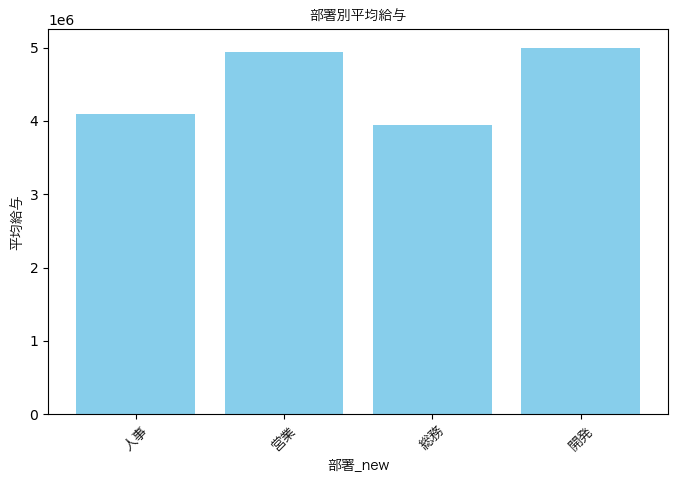

In [16]:
# 上記のエンコーディング名を使い、CSVを読み込む
df = pd.read_csv(csv_file, encoding="SHIFT_JIS")

# 列名の変更(newをつけた)
df.columns = ["社員ID_new", "氏名_new", "部署_new", "年齢_new", "入社年_new", "給与_new"]

#社員IDを行名に変更
df.set_index("社員ID_new", inplace=True)

# 欠損値を補完（例: 空白を0や適切な値で補完）
df.fillna({"年齢_new": df["年齢_new"].median(), "給与_new": df["給与_new"].median()}, inplace=True)

# SQLiteデータベースに接続
conn = sqlite3.connect("employees.db")
cursor = conn.cursor()

# テーブルを作成
cursor.execute('''
CREATE TABLE IF NOT EXISTS employees (
    社員ID_new INTEGER,
    氏名_new TEXT,
    部署_new TEXT,
    年齢_new INTEGER,
    入社年_new INTEGER,
    給与_new INTEGER
)
''')

# データをSQLiteに挿入
df.to_sql("employees", conn, if_exists="replace", index=False)

# データを取得し表示
for row in cursor.execute("SELECT * FROM employees"):
    print(row)

##目的を絞ってデータを取得し表示
# ① 年齢順に社員を表示
print("年齢順の社員一覧:")
for row in cursor.execute("SELECT * FROM employees ORDER BY 年齢_new"):
    print(row)

# ② 部署ごとの平均給与を集計
print("\n部署ごとの平均給与:")
cursor.execute("SELECT 部署_new, AVG(給与_new) FROM employees GROUP BY 部署_new")
for row in cursor.fetchall():
    print(row)

# ③ 入社年が2018年以降の社員一覧を抽出
print("\n入社年が2018年以降の社員一覧:")
cursor.execute("SELECT * FROM employees WHERE 入社年_new >= 2018")
for row in cursor.fetchall():
    print(row)

# bonus: matplotlibで部署別平均給与の棒グラフを表示
import matplotlib.font_manager as fm
# 日本語フォントのパスを指定（Macの場合）
font_path = "/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc"  # Macの場合の一例
prop = fm.FontProperties(fname=font_path)
## 本格的に図を作成
cursor.execute("SELECT 部署_new, AVG(給与_new) FROM employees GROUP BY 部署_new")
data = cursor.fetchall()
部署_new = [row[0] for row in data]
平均給与_new = [row[1] for row in data]

plt.figure(figsize=(8, 5))
plt.bar(部署_new, 平均給与_new, color='skyblue')
plt.xlabel("部署_new", fontproperties=prop)
plt.ylabel("平均給与", fontproperties=prop)
plt.title("部署別平均給与", fontproperties=prop)
plt.xticks(rotation=45, fontproperties=prop)
plt.show()